# Day 2: Fundamental & Macro Features

## 🎯 Learning Objectives
- Create fundamental ratio features
- Integrate macroeconomic data
- Cross-asset features

---

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Download multiple assets for cross-asset features
# Use correct Yahoo Finance ticker symbols
tickers = {'SPY': 'SPY', 'TLT': 'TLT', 'GLD': 'GLD', 'VIX': '^VIX', 'USO': 'USO'}
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = {}
for name, ticker in tickers.items():
    try:
        temp = yf.download(ticker, start=start_date, end=end_date, progress=False)
        # Handle multi-level columns from yfinance
        if isinstance(temp.columns, pd.MultiIndex):
            temp.columns = temp.columns.get_level_values(0)
        data[name] = temp['Close']
        print(f"  ✅ {name}: {len(temp)} days")
    except Exception as e:
        print(f"  ⚠️ Warning: Could not download {name}: {e}")

prices = pd.DataFrame(data).dropna()
print(f"\n✅ Combined Data: {len(prices)} days")

📥 Downloading data...
  ✅ SPY: 1254 days
  ✅ TLT: 1254 days
  ✅ GLD: 1254 days
  ✅ VIX: 1255 days
  ✅ USO: 1254 days

✅ Combined Data: 1254 days


In [3]:
# Create cross-asset features
df = pd.DataFrame(index=prices.index)

# Stock returns
df['spy_return'] = prices['SPY'].pct_change()
df['spy_return_5d'] = prices['SPY'].pct_change(5)
df['spy_return_20d'] = prices['SPY'].pct_change(20)

# Cross-asset returns
for t in ['TLT', 'GLD', 'USO']:
    if t in prices.columns:
        df[f'{t.lower()}_return'] = prices[t].pct_change()
        df[f'{t.lower()}_return_5d'] = prices[t].pct_change(5)

# Stock-Bond relationship
if 'TLT' in prices.columns:
    df['stock_bond_ratio'] = prices['SPY'] / prices['TLT']
    df['stock_bond_ratio_change'] = df['stock_bond_ratio'].pct_change(5)

# VIX features (fear gauge)
if 'VIX' in prices.columns:
    df['vix'] = prices['VIX']
    df['vix_change'] = prices['VIX'].pct_change()
    df['vix_sma'] = prices['VIX'].rolling(20).mean()
    df['vix_ratio'] = prices['VIX'] / df['vix_sma']

print(f"\n📊 Created {len(df.columns)} features")


📊 Created 15 features


In [4]:
# Correlation analysis
df_clean = df.dropna()
corr = df_clean.corr()['spy_return'].sort_values(ascending=False)

print("\n" + "="*60)
print("CORRELATION WITH SPY RETURNS")
print("="*60)
print(corr)


CORRELATION WITH SPY RETURNS
spy_return                 1.000000
spy_return_5d              0.410763
stock_bond_ratio_change    0.283890
spy_return_20d             0.209973
uso_return                 0.181269
gld_return                 0.123785
tlt_return                 0.066817
tlt_return_5d              0.065573
gld_return_5d              0.039093
stock_bond_ratio           0.033770
uso_return_5d              0.019081
vix_sma                    0.016024
vix                       -0.203901
vix_ratio                 -0.370298
vix_change                -0.748780
Name: spy_return, dtype: float64


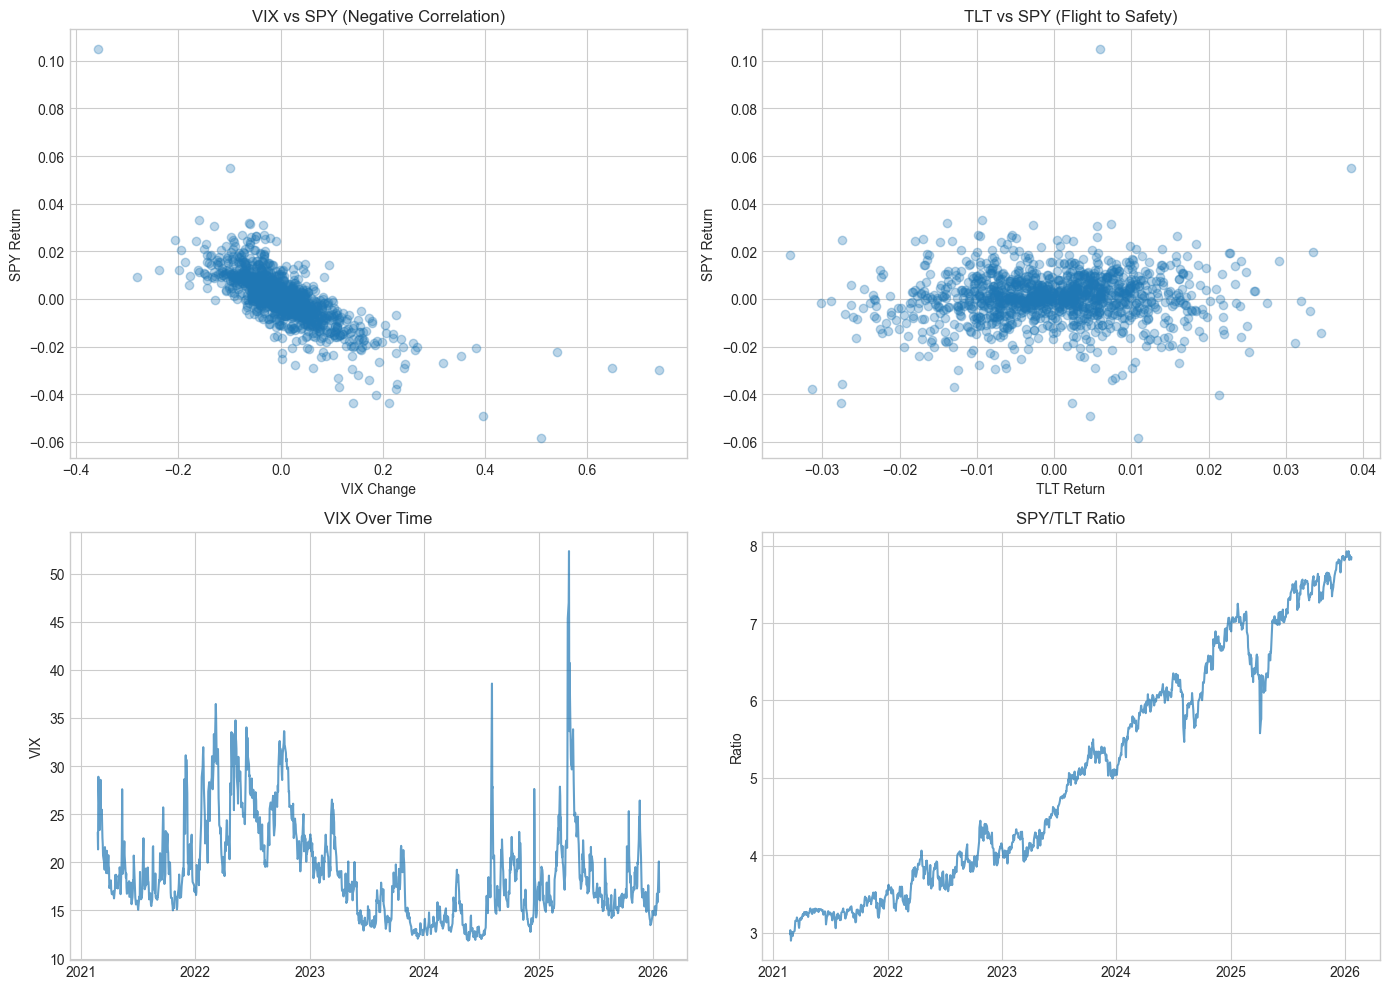

In [5]:
# Visualize cross-asset relationships
if 'VIX' in prices.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0,0].scatter(df_clean['vix_change'], df_clean['spy_return'], alpha=0.3)
    axes[0,0].set_xlabel('VIX Change')
    axes[0,0].set_ylabel('SPY Return')
    axes[0,0].set_title('VIX vs SPY (Negative Correlation)')
    
    if 'TLT' in prices.columns:
        axes[0,1].scatter(df_clean['tlt_return'], df_clean['spy_return'], alpha=0.3)
        axes[0,1].set_xlabel('TLT Return')
        axes[0,1].set_ylabel('SPY Return')
        axes[0,1].set_title('TLT vs SPY (Flight to Safety)')
    
    axes[1,0].plot(df_clean.index, df_clean['vix'], alpha=0.7)
    axes[1,0].set_title('VIX Over Time')
    axes[1,0].set_ylabel('VIX')
    
    if 'TLT' in prices.columns:
        axes[1,1].plot(df_clean.index, df_clean['stock_bond_ratio'], alpha=0.7)
        axes[1,1].set_title('SPY/TLT Ratio')
        axes[1,1].set_ylabel('Ratio')
    
    plt.tight_layout()
    plt.show()

In [6]:
# Build predictive model with macro features
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Target: next day SPY direction
df['target'] = np.sign(df['spy_return'].shift(-1))
df['target'] = df['target'].map({1: 1, -1: 0, 0: 1})

df_model = df.dropna()

feature_cols = [c for c in df_model.columns if c not in ['spy_return', 'target']]

# Split
train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

X_train = train[feature_cols]
y_train = train['target']
X_test = test[feature_cols]
y_test = test['target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train
model = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train)

print(f"\nTest Accuracy: {accuracy_score(y_test, model.predict(X_test_scaled)):.1%}")


Test Accuracy: 48.2%


In [7]:
# Today's signal
latest = df_model[feature_cols].iloc[[-1]]
latest_scaled = scaler.transform(latest)
pred = model.predict(latest_scaled)[0]
prob = model.predict_proba(latest_scaled)[0]

print("\n" + "="*60)
print("📊 MACRO-BASED SIGNAL FOR SPY")
print("="*60)
print(f"\nDate: {df_model.index[-1].strftime('%Y-%m-%d')}")
print(f"\nCross-Asset Indicators:")
if 'vix' in df_model.columns:
    print(f"  VIX: {df_model['vix'].iloc[-1]:.1f}")
    print(f"  VIX Ratio to 20d MA: {df_model['vix_ratio'].iloc[-1]:.2f}")
if 'stock_bond_ratio' in df_model.columns:
    print(f"  Stock/Bond Ratio: {df_model['stock_bond_ratio'].iloc[-1]:.2f}")
print(f"\n🎯 Signal: {'📈 BULLISH' if pred == 1 else '📉 BEARISH'}")
print(f"   Confidence: {max(prob):.1%}")


📊 MACRO-BASED SIGNAL FOR SPY

Date: 2026-01-20

Cross-Asset Indicators:
  VIX: 20.1
  VIX Ratio to 20d MA: 1.33
  Stock/Bond Ratio: 7.82

🎯 Signal: 📉 BEARISH
   Confidence: 62.0%


---
## 📅 Tomorrow: Time-Based Features